# Distribution Estimation

In [1]:
import os, sys
cwd = os.getcwd()
# sys.path.insert(0, f"{cwd}/../")
sys.path.insert(0, "/home/emmanuel/code/rbig")

# RBIG Packages
from rbig.data import ToyData
from rbig.information.kde import KDESklearn, KDEScipy

from typing import Iterable, Optional, Dict, NamedTuple, Tuple, Union
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

import numpy as np
from scipy import stats

# Plot Functions
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use(["seaborn-paper"])
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['axes.labelsize'] = 12

%load_ext autoreload
%autoreload 2

## Data

Entropy: 2.0234


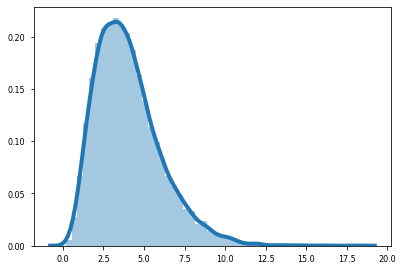

In [2]:
seed = 123
n_samples = 10_000
a = 4

# initialize data distribution
data_dist = stats.gamma(a=a)

# get some samples
X = data_dist.rvs(size=(n_samples, 1), random_state=seed)

print(f"Entropy: {data_dist.entropy():.4f}")
# plot distribution
sns.distplot(X)

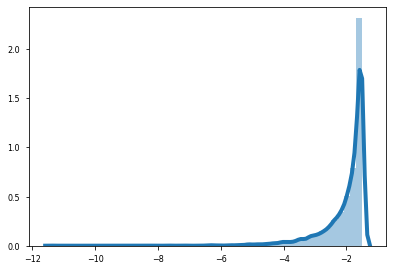

In [3]:
sns.distplot(data_dist.logpdf(X))

## PDF Estimation

## 1. Histogram (Generic, Fast)

In [114]:
from rbig.information.histogram import ScipyHistogram, hist_entropy
from rbig.transform import QuantileGaussianization

In [115]:
quant_clf = QuantileGaussianization(n_quantiles=1_000, )

quant_clf.fit(X)

QuantileGaussianization(n_quantiles=1000, random_state=None, subsample=100000.0,
                        support_extension=10)

### Log PDF

In [120]:
X_prob = quant_clf.log_abs_det_jacobian(X)
X_prob.shape

# %timeit _ = hist_clf.score_samples(X)

(10000, 1)

#### Viz - Log PDF

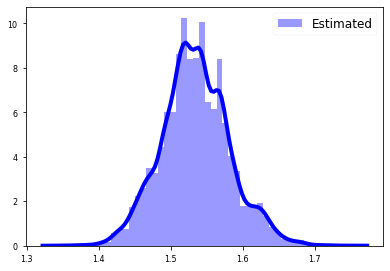

In [119]:
sns.distplot(X_prob, color='blue', label='Estimated')
plt.legend()
# plt.legend(fontsize=20)

#### Viz - Log PDF Line

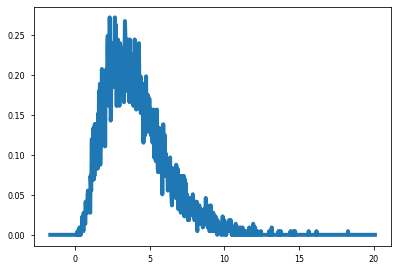

In [8]:
plt.plot(hist_clf.estimator_._hbins, hist_clf.estimator_._hpdf[:-1])

### CDF

In [9]:
X_cdf = hist_clf.cdf(X)

%timeit _ = hist_clf.cdf(X)

892 µs ± 736 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Viz - Distribution

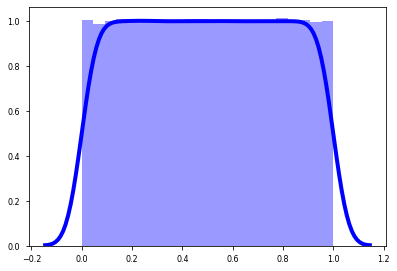

In [10]:
sns.distplot(X_cdf, color='blue', label='Estimated')
plt.legend(fontsize=20)

#### Viz - Lines

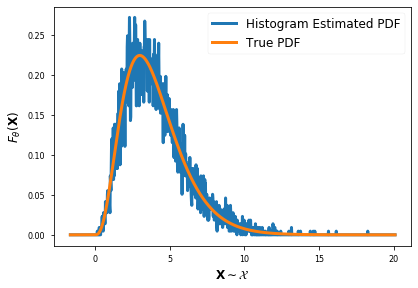

In [11]:
plt.plot(hist_clf.estimator_._hbins, hist_clf.estimator_._hpdf[1:], linewidth=3, label='Histogram Estimated PDF')
plt.plot(hist_clf.estimator_._hbins, data_dist.pdf(hist_clf.estimator_._hbins), linewidth=3, label='True PDF')
plt.xlabel(r'$\mathbf{X}\sim \mathcal{X}$',)
plt.ylabel(r'$F_\theta(\mathbf{X})$',)
plt.legend()

### PPF (Inverse CDF)

In [363]:
X_approx = hist_clf.ppf(X_cdf)

%timeit _ = hist_clf.ppf(X_cdf)

1.14 ms ± 581 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Viz - Distribution

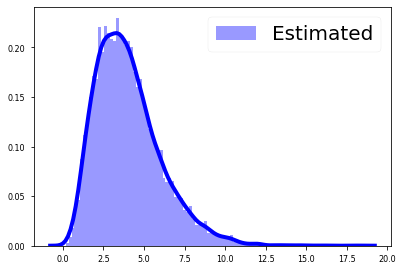

In [364]:
sns.distplot(X_approx, bins=100, color='blue', label='Estimated')

plt.legend(fontsize=20)

#### Viz - PPF Function

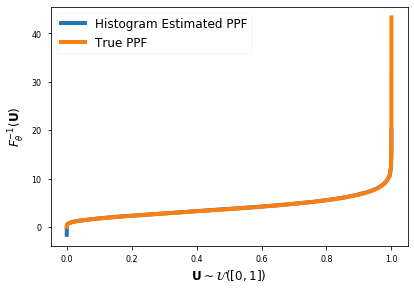

In [374]:
plt.plot(hist_clf.estimator_._hcdf, hist_clf.estimator_._hbins, label='Histogram Estimated PPF');
plt.plot(hist_clf.estimator_._hcdf, data_dist.ppf(hist_clf.estimator_._hcdf), label='True PPF');
plt.xlabel(r'$\mathbf{U}\sim \mathcal{U}([0, 1])$',)
plt.ylabel(r'$F_\theta^{-1}(\mathbf{U})$',)
plt.legend()

### Entropy

In [280]:

H_X_hist = hist_clf.entropy()

print(f"Entropy: {H_X_hist:.4f}")

Entropy: 2.0172


## 2. KDE - Scipy Implementation (Small Data)

In [63]:
from scipy import stats
from rbig.information.kde import KDEScipy, kde_entropy_uni

In [76]:
kde_scipy_clf = KDEScipy(bw_method='scott', n_quantiles=1_000, support_extension=10)

kde_scipy_clf.fit(X)

KDEScipy(bw_method='scott', interp_kind='linear', n_quantiles=1000,
         support_extension=50)

### Log PDF

In [77]:
X_lprob = kde_scipy_clf.logpdf(X)

%timeit _ = kde_scipy_clf.logpdf(X)

830 µs ± 693 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Viz - Distribution

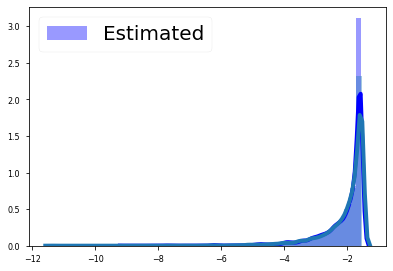

In [78]:
sns.distplot(X_lprob, color='blue', label='Estimated')
sns.distplot(data_dist.logpdf(X))
plt.legend(fontsize=20)

#### Viz - PDF Lines

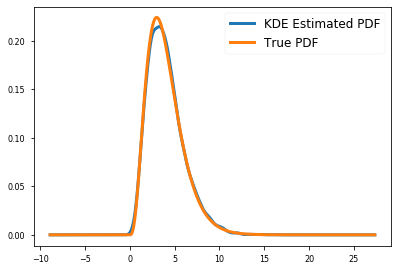

In [79]:
plt.plot(kde_scipy_clf.hbins_, kde_scipy_clf.hpdf_, linewidth=3, label='KDE Estimated PDF')
plt.plot(kde_scipy_clf.hbins_, data_dist.pdf(kde_scipy_clf.hbins_), linewidth=3, label='True PDF')
plt.legend()

#### Viz - Log PDF Lines

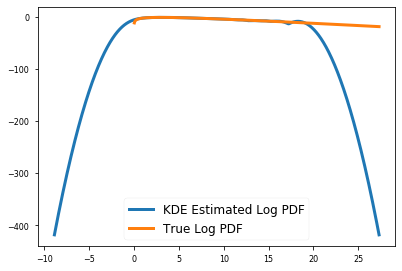

In [80]:
plt.plot(kde_scipy_clf.hbins_, np.log(kde_scipy_clf.hpdf_), linewidth=3, label='KDE Estimated Log PDF')
plt.plot(kde_scipy_clf.hbins_, data_dist.logpdf(kde_scipy_clf.hbins_), linewidth=3, label='True Log PDF')
plt.legend(fontsize=12)
plt.show()

### CDF Function

In [81]:
X_cdf = kde_scipy_clf.cdf(X)

%timeit _ = kde_scipy_clf.cdf(X)

518 µs ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Viz - Distribution

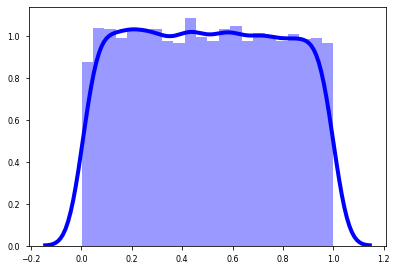

In [82]:
sns.distplot(X_cdf, color='blue', label='Estimated')

#### Viz - CDF Lines

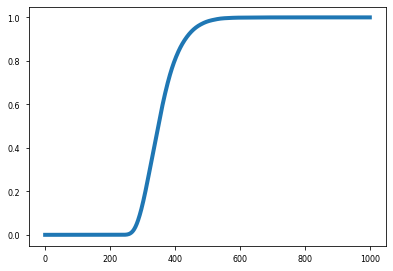

In [83]:
plt.plot(kde_scipy_clf.hcdf_)

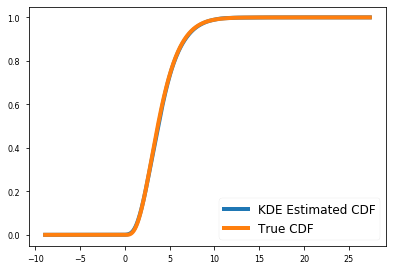

In [84]:
plt.plot(kde_scipy_clf.hbins_, kde_scipy_clf.hcdf_, label='KDE Estimated CDF')
plt.plot(kde_scipy_clf.hbins_, data_dist.cdf(kde_scipy_clf.hbins_), label='True CDF')
plt.legend(fontsize=12)

### PPF Function

In [73]:
X_ppf = kde_scipy_clf.ppf(X_cdf)

%timeit _ = kde_scipy_clf.ppf(X)

44.3 µs ± 27.6 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### Viz - Distribution

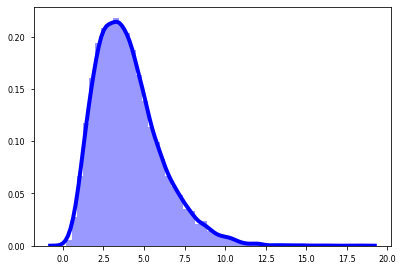

In [74]:
sns.distplot(X_ppf, color='blue', label='Estimated')

#### Viz - Line

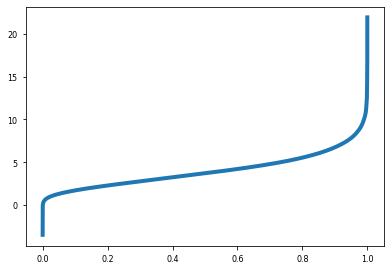

In [75]:
plt.plot(kde_scipy_clf.hcdf_, kde_scipy_clf.hbins_)

## 3. KDE (Knn Approximation)

In [384]:
from scipy import stats
from rbig.information.kde import KDESklearn, kde_entropy_uni

In [392]:
algorithm = 'kd_tree'
n_qauntiles = 1_000
support_extesion = 10


kde_sk_clf = KDESklearn(
    algorithm=algorithm, 
    n_quantiles=n_qauntiles, 
    support_extension=support_extesion
)

kde_sk_clf.fit(X)

KDESklearn(algorithm='kd_tree', kernel='gaussian', kwargs={},
           metric='euclidean', n_quantiles=1000, support_extension=10)

### Log PDF

In [394]:
X_lprob = kde_sk_clf.logpdf(X)

%timeit _ = kde_sk_clf.logpdf(X)

886 µs ± 1.79 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


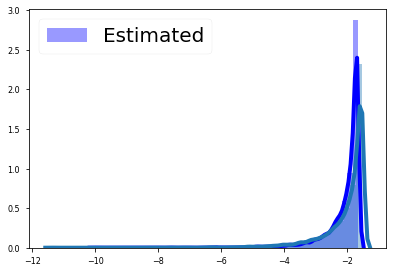

In [395]:
sns.distplot(X_lprob, color='blue', label='Estimated')
sns.distplot(data_dist.logpdf(X))
plt.legend(fontsize=20)

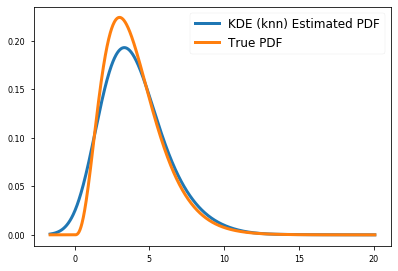

In [396]:
plt.plot(kde_sk_clf.hbins_, kde_sk_clf.hpdf_, linewidth=3, label='KDE (knn) Estimated PDF')
plt.plot(kde_sk_clf.hbins_, data_dist.pdf(kde_sk_clf.hbins_), linewidth=3, label='True PDF')
plt.legend()

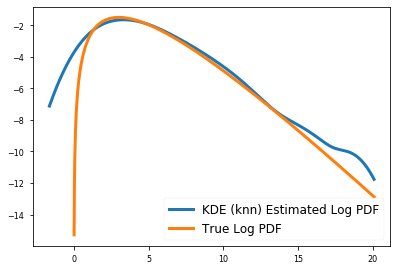

In [397]:
plt.plot(kde_sk_clf.hbins_, np.log(kde_sk_clf.hpdf_), linewidth=3, label='KDE (knn) Estimated Log PDF')
plt.plot(kde_sk_clf.hbins_, data_dist.logpdf(kde_sk_clf.hbins_), linewidth=3, label='True Log PDF')
plt.legend(fontsize=12)
plt.show()

### CDF Function

In [398]:
X_cdf = kde_sk_clf.cdf(X)

%timeit _ = kde_sk_clf.cdf(X)

550 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


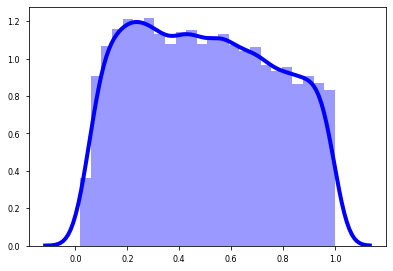

In [399]:
sns.distplot(X_cdf, color='blue', label='Estimated')

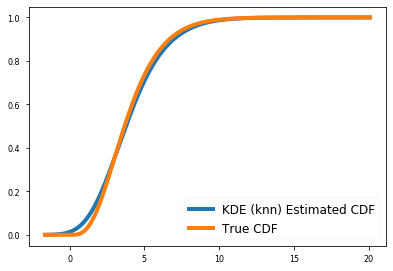

In [400]:
plt.plot(kde_sk_clf.hbins_, kde_sk_clf.hcdf_, label='KDE (knn) Estimated CDF')
plt.plot(kde_sk_clf.hbins_, data_dist.cdf(kde_sk_clf.hbins_), label='True CDF')
plt.legend(fontsize=12)

### PPF Function

In [401]:
X_ppf = kde_sk_clf.ppf(X_cdf)

%timeit _ = kde_sk_clf.ppf(X)

44.5 µs ± 35 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


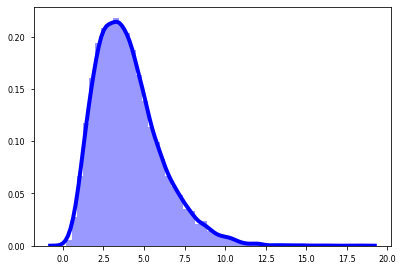

In [402]:
sns.distplot(X_ppf, color='blue', label='Estimated')

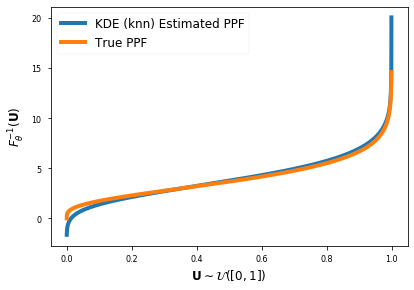

In [404]:
plt.plot(kde_sk_clf.hcdf_, kde_sk_clf.hbins_, label='KDE (knn) Estimated PPF');
plt.plot(kde_sk_clf.hcdf_, data_dist.ppf(kde_sk_clf.hcdf_), label='True PPF');
plt.xlabel(r'$\mathbf{U}\sim \mathcal{U}([0, 1])$',)
plt.ylabel(r'$F_\theta^{-1}(\mathbf{U})$',)
plt.legend()